In [25]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline, make_union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cross_validation import ShuffleSplit
from pandas import Series
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

## ShuffleSplit

ShuffleSplit is another cross validation method. It differs from k-fold cross validation in that in k-fold one fold is the test set while the remaining data is the train set. ShuffleSplit, during each round n you should only use the training and test set from iteration n. Also, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
credit_data = pd.read_csv('german_credit.csv')

In [3]:
lb_make = LabelEncoder()

credit_data2 = credit_data.copy()
credit_data2['AgeCat'] = pd.cut(credit_data2['Age (years)'], 4)
credit_data2['AgeCat'] = lb_make.fit_transform(credit_data2["AgeCat"].astype(str))

credit_data2['CredAmtCat'] = pd.cut(credit_data2['Credit Amount'],3)
credit_data2['CredAmtCat'] = lb_make.fit_transform(credit_data2["CredAmtCat"].astype(str))

credit_data2['CredDurCat'] = pd.cut(credit_data2['Duration of Credit (month)'],4)
credit_data2['CredDurCat'] = lb_make.fit_transform(credit_data2["CredDurCat"].astype(str))

In [4]:
credit_data2 = credit_data2.drop(["Age (years)", "Credit Amount", "Duration of Credit (month)"], axis=1)

In [5]:
X = credit_data2.loc[:, credit_data.columns != 'Creditability']
y = credit_data2["Creditability"]
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=1/3., random_state=42)

In [6]:
## function to select the columns

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


In [19]:

pipeline = Pipeline(steps = [
        ("features", make_union(
                ColumnSelector(list(X)),
                )),
                ("model",RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

pipeline.score(X_validation, y_validation)

print("RF Score before CV: %s" % pipeline.score(X_validation, y_validation))

# get list of hyperparameters

hyperparameters = { 'model__max_depth': [50, 70,90],
                    'model__min_samples_leaf': [1,2,3]
                  }

clf = GridSearchCV(pipeline, hyperparameters, cv=10)

clf.fit(X_train, y_train)

print("RF Score after CV: %s" % clf.score(X_validation, y_validation))

# get list of hyperparameters

cv = ShuffleSplit(X_train.shape[0], test_size=0.2) 

clf_ss = GridSearchCV(pipeline, hyperparameters, cv= cv)

clf_ss.fit(X_train, y_train)

clf_ss.fit(X_train, y_train)

print("RF Score after ShuffleSplit: %s" % clf_ss.score(X_validation, y_validation))

RF Score before CV: 0.739520958084
RF Score after CV: 0.793413173653
RF Score after ShuffleSplit: 0.793413173653


## Time series cross validation

Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

Cross validation in larger datasets take longer because of folds. ShuffleSplit is faster in this case because it trains the algorithm on a percentage of the data. 

download the data from here: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

In [20]:
df = pd.read_csv('monthly-sunspots.csv')

In [21]:
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


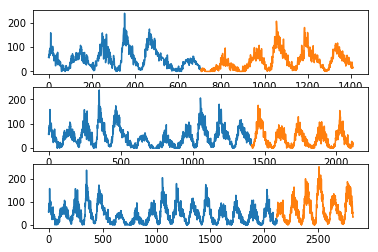

In [26]:
series = Series.from_csv('monthly-sunspots.csv', header=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()